In [132]:
import tensorflow as tf
print(tf.__version__)

2.10.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [133]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [134]:
# Save the input and target variables
print(diabetes_dataset.keys())


dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


In [135]:
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [136]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0))/ targets.std()
targets


array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [137]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

#### Train a feedforward neural network model

In [138]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
    Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
    ])
    return model

model = get_model()


In [139]:
# Print the model summary

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 128)               1408      
                                                                 
 dense_148 (Dense)           (None, 128)               16512     
                                                                 
 dense_149 (Dense)           (None, 128)               16512     
                                                                 
 dense_150 (Dense)           (None, 128)               16512     
                                                                 
 dense_151 (Dense)           (None, 128)               16512     
                                                                 
 dense_152 (Dense)           (None, 128)               16512     
                                                                 
 dense_153 (Dense)           (None, 1)               

In [140]:
# Compile the model

model.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [141]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [142]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.9219 - mae: 0.7629 - 16ms/epoch - 8ms/step


[0.9219366908073425, 0.7628858685493469]

#### Plot the learning curves

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline

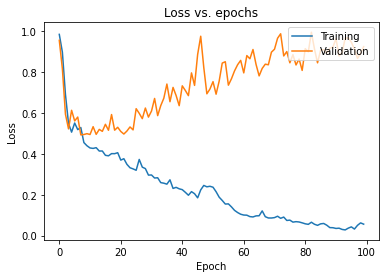

In [144]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [145]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [146]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [147]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5,0.3)

In [148]:
# Compile the model

model.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [149]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, 
                    validation_split=0.15, batch_size=64, verbose=False)


In [150]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.6549 - mae: 0.6491 - 14ms/epoch - 7ms/step


[0.6548935174942017, 0.6491245627403259]

#### Plot the learning curves

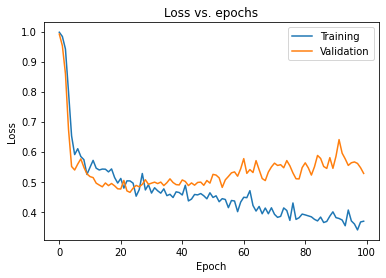

In [151]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [152]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):

    def on_train_begin(self, logs=None):
        print("Starting training...")

    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")

    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Startin batch {batch}")

    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")

    def on_train_end(self, logs=None):
        print("Finished training!")


In [153]:
class TestingCallback(Callback):

    def on_test_begin(self, logs=None):
        print("Starting testing...")

    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Startin batch {batch}")

    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished batch {batch}")

    def on_test_end(self, logs=None):
        print("Finished testing!")

In [154]:
class PredictionCallback(Callback):

    def on_predict_begin(self, logs=None):
        print("Starting prediction...")

    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction: Startin batch {batch}")

    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction: Finished batch {batch}")

    def on_predict_end(self, logs=None):
        print("Finished prediction!")

In [155]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [156]:
# Compile the model

model.compile(optimizer='adam',loss="mse")

#### Train the model with the callback

In [157]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting training...
Starting epoch 0
Training: Startin batch 0
Training: Finished batch 0
Training: Startin batch 1
Training: Finished batch 1
Training: Startin batch 2
Training: Finished batch 2
Training: Startin batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Startin batch 0
Training: Finished batch 0
Training: Startin batch 1
Training: Finished batch 1
Training: Startin batch 2
Training: Finished batch 2
Training: Startin batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Startin batch 0
Training: Finished batch 0
Training: Startin batch 1
Training: Finished batch 1
Training: Startin batch 2
Training: Finished batch 2
Training: Startin batch 3
Training: Finished batch 3
Finished epoch 2
Finished training!


In [158]:
# Evaluate the model
model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])


Starting testing...
Testing: Startin batch 0
Testing: Finished batch 0
Testing: Startin batch 1
Testing: Finished batch 1
Finished testing!


0.9497710466384888

In [159]:
# Make predictions with the model

model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Starting prediction...
Prediction: Startin batch 0
Prediction: Finished batch 0
Prediction: Startin batch 1
Prediction: Finished batch 1
Finished prediction!


array([[-0.02966837],
       [-0.07951263],
       [ 0.00337385],
       [-0.08935503],
       [ 0.0537185 ],
       [-0.11999797],
       [ 0.06283808],
       [ 0.0567084 ],
       [-0.04394898],
       [-0.11865936],
       [ 0.05988974],
       [ 0.04134431],
       [ 0.04617201],
       [-0.090599  ],
       [-0.08246537],
       [ 0.02922022],
       [ 0.03641322],
       [-0.12399101],
       [-0.12587081],
       [-0.00987999],
       [-0.02014095],
       [-0.06431837],
       [-0.16942362],
       [ 0.01463565],
       [-0.10235825],
       [-0.06214716],
       [-0.11584182],
       [-0.09072982],
       [-0.04032846],
       [-0.1618552 ],
       [-0.04021848],
       [-0.02418765],
       [ 0.06349365],
       [-0.1349741 ],
       [-0.11134724],
       [-0.1731626 ],
       [-0.00825585],
       [-0.17154531],
       [-0.08196508],
       [ 0.04995781],
       [-0.12263884],
       [-0.14658967],
       [-0.01394483],
       [-0.15628265],
       [-0.00086667]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [160]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam',loss='mse')
unreg_history = unregularised_model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64,
                                        verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


In [161]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.6148 - 16ms/epoch - 8ms/step


0.6147708296775818

In [162]:
# Re-train the regularised model

regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam',loss='mse')
reg_history = regularised_model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64,
                                        verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [163]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.4701 - 15ms/epoch - 7ms/step


0.4701477587223053

#### Plot the learning curves

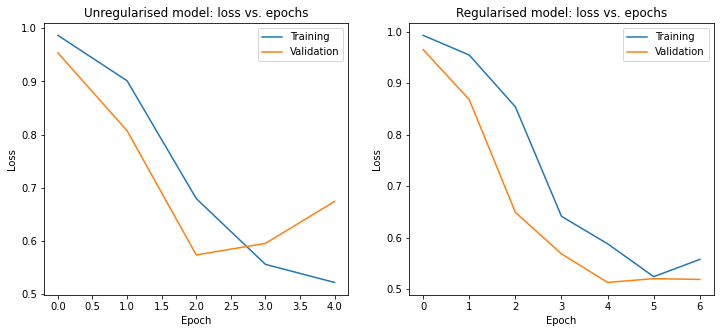

In [164]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()